Transform daily upper and lower bound data into a monthly average value which will serve as a placeholder for the SNB policy target for the range of time betwen January 2000 and June 2019. Post-processing the average for one month will be reported on the 1st of the following month. Our data begins in January 2000, so the value on January 1st will simply be the first available value, with following records being reported as described (average of the previous month). Finally, we drop the last value, which is the average for the month of June (reported July 1), because we will have an explicit policy rate from a different data set beginning on that date.

In [59]:
import psycopg2
import os
import pandas as pd
from sqlalchemy import create_engine

# Set up connection parameters from environment variables
dbname = os.environ.get('DBNAME')
user = os.environ.get('DBUSER')
password = os.environ.get('DBPASS')
host = os.environ.get('DBHOST')
port = os.environ.get('DBPORT')

# Connect to the PostgreSQL database
conn_str = f'postgresql://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(conn_str)

# SQL query
query = '''
WITH MonthlyAverages AS (
  SELECT
    DATE_TRUNC('month', date) + INTERVAL '1 month' - INTERVAL '1 day' AS date,
    AVG((lower_bound + upper_bound) / 2.0) AS value
  FROM
    targetranges
  GROUP BY
    DATE_TRUNC('month', date)
)
SELECT
  (date + INTERVAL '1 day')::date AS date,
  value
FROM
  MonthlyAverages

UNION ALL

SELECT
  '2000-01-01'::date AS report_date,
  (SELECT (lower_bound + upper_bound) / 2.0
   FROM targetranges
   ORDER BY date ASC
   LIMIT 1) AS value
ORDER BY
  date;
'''

# Read the data into a Pandas DataFrame
SNB_old = pd.read_sql_query(query, engine)

# Drop the last row from the DataFrame
SNB_old = SNB_old[:-1]

# Close the connection
engine.dispose()

# Show the resulting DataFrame
print(SNB_old)


           date     value
0    2000-01-01  1.750000
1    2000-02-01  1.750000
2    2000-03-01  2.202381
3    2000-04-01  2.478261
4    2000-05-01  3.000000
..          ...       ...
229  2019-02-01 -0.750000
230  2019-03-01 -0.750000
231  2019-04-01 -0.750000
232  2019-05-01 -0.750000
233  2019-06-01 -0.750000

[234 rows x 2 columns]


Extract and examine the explicit policy target from the SNB, which began targeting specific value in June 2019. Values for a month are reported as of the 1st of the following month.

In [60]:
import psycopg2
import os
import pandas as pd
from sqlalchemy import create_engine
from pandas.tseries.offsets import DateOffset

# Set up connection parameters from environment variables
dbname = os.environ.get('DBNAME')
user = os.environ.get('DBUSER')
password = os.environ.get('DBPASS')
host = os.environ.get('DBHOST')
port = os.environ.get('DBPORT')

# Connect to the PostgreSQL database
conn_str = f'postgresql://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(conn_str)

# SQL query to select date and value from the targetrates table
query = '''
SELECT date, value FROM targetrates;
'''

# Read the data into a Pandas DataFrame
SNB_new = pd.read_sql_query(query, engine)

# Index the dates forward by one month to the first of the next month
SNB_new['date'] = pd.to_datetime(SNB_new['date']) + DateOffset(months=1)
SNB_new['date'] = SNB_new['date'].apply(lambda d: d.replace(day=1))

# Close the connection
engine.dispose()

# Print the resulting DataFrame
print(SNB_new)


         date  value
0  2019-07-01  -0.75
1  2019-08-01  -0.75
2  2019-09-01  -0.75
3  2019-10-01  -0.75
4  2019-11-01  -0.75
5  2019-12-01  -0.75
6  2020-01-01  -0.75
7  2020-02-01  -0.75
8  2020-03-01  -0.75
9  2020-04-01  -0.75
10 2020-05-01  -0.75
11 2020-06-01  -0.75
12 2020-07-01  -0.75
13 2020-08-01  -0.75
14 2020-09-01  -0.75
15 2020-10-01  -0.75
16 2020-11-01  -0.75
17 2020-12-01  -0.75
18 2021-01-01  -0.75
19 2021-02-01  -0.75
20 2021-03-01  -0.75
21 2021-04-01  -0.75
22 2021-05-01  -0.75
23 2021-06-01  -0.75
24 2021-07-01  -0.75
25 2021-08-01  -0.75
26 2021-09-01  -0.75
27 2021-10-01  -0.75
28 2021-11-01  -0.75
29 2021-12-01  -0.75
30 2022-01-01  -0.75
31 2022-02-01  -0.75
32 2022-03-01  -0.75
33 2022-04-01  -0.75
34 2022-05-01  -0.75
35 2022-06-01  -0.75
36 2022-07-01  -0.25
37 2022-08-01  -0.25
38 2022-09-01  -0.25
39 2022-10-01   0.50
40 2022-11-01   0.50
41 2022-12-01   0.50
42 2023-01-01   1.00
43 2023-02-01   1.00
44 2023-03-01   1.00
45 2023-04-01   1.50
46 2023-05-01

Using SNB_new and SNB_old dataframes created above, create a new dataframe, SNB_policy which represents a continuous set of policy targets from January 2000 through present.

In [61]:
import pandas as pd

# Convert the 'date' columns in both DataFrames to pandas datetime format
SNB_old['date'] = pd.to_datetime(SNB_old['date'])
SNB_new['date'] = pd.to_datetime(SNB_new['date'])

# Merge SNB_old and SNB_new DataFrames
SNB_policy = pd.concat([SNB_old, SNB_new])

# Sort by date
SNB_policy.sort_values(by='date', inplace=True)

# Remove duplicates, keeping the first occurrence by default
SNB_policy.drop_duplicates(subset='date', keep='first', inplace=True)

# Print the resulting DataFrame
print(SNB_policy)


         date     value
0  2000-01-01  1.750000
1  2000-02-01  1.750000
2  2000-03-01  2.202381
3  2000-04-01  2.478261
4  2000-05-01  3.000000
..        ...       ...
47 2023-06-01  1.500000
48 2023-07-01  1.750000
49 2023-08-01  1.750000
50 2023-09-01  1.750000
51 2023-10-01  1.750000

[286 rows x 2 columns]


Extract savings deposit rate data from the SNB and offset by one month to match format of the other datasets.

In [62]:
import pandas as pd
from sqlalchemy import create_engine

# Set up connection parameters from environment variables
dbname = os.environ.get('DBNAME')
user = os.environ.get('DBUSER')
password = os.environ.get('DBPASS')
host = os.environ.get('DBHOST')
port = os.environ.get('DBPORT')

# Connect to the PostgreSQL database
conn_str = f'postgresql://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(conn_str)

# SQL query to select date and value from the depositrates table
query = '''
SELECT date, value FROM depositrates;
'''

# Read the data into a Pandas DataFrame
SNB_deposit = pd.read_sql_query(query, engine)

# Convert the 'date' column to pandas datetime format and index forward by one month to the first of the next month
SNB_deposit['date'] = pd.to_datetime(SNB_deposit['date']) + pd.offsets.MonthBegin(1)

# Close the connection
engine.dispose()

# Print the resulting DataFrame
print(SNB_deposit)


          date     value
0   2000-01-01  1.190000
1   2000-02-01  1.190000
2   2000-03-01  1.270000
3   2000-04-01  1.350000
4   2000-05-01  1.350000
..         ...       ...
280 2023-05-01  0.334940
281 2023-06-01  0.460714
282 2023-07-01  0.526190
283 2023-08-01  0.597059
284 2023-09-01  0.656765

[285 rows x 2 columns]


Create a combined dataset with policy targets and deposit rates for analysis.

In [98]:
import pandas as pd

# Assuming SNB_policy and SNB_deposit are already defined DataFrames with a 'date' column

# Merge SNB_policy and SNB_deposit on the 'date' column
SNB_data = pd.merge(SNB_policy[['date', 'value']], SNB_deposit[['date', 'value']], on='date', how='left')

# Rename the columns appropriately
SNB_data.rename(columns={'value_x': 'policy', 'value_y': 'deposit'}, inplace=True)

# Print the resulting DataFrame
print(SNB_data)


          date    policy   deposit
0   2000-01-01  1.750000  1.190000
1   2000-02-01  1.750000  1.190000
2   2000-03-01  2.202381  1.270000
3   2000-04-01  2.478261  1.350000
4   2000-05-01  3.000000  1.350000
..         ...       ...       ...
281 2023-06-01  1.500000  0.460714
282 2023-07-01  1.750000  0.526190
283 2023-08-01  1.750000  0.597059
284 2023-09-01  1.750000  0.656765
285 2023-10-01  1.750000       NaN

[286 rows x 3 columns]


Chart policy target and deposit rates over time.

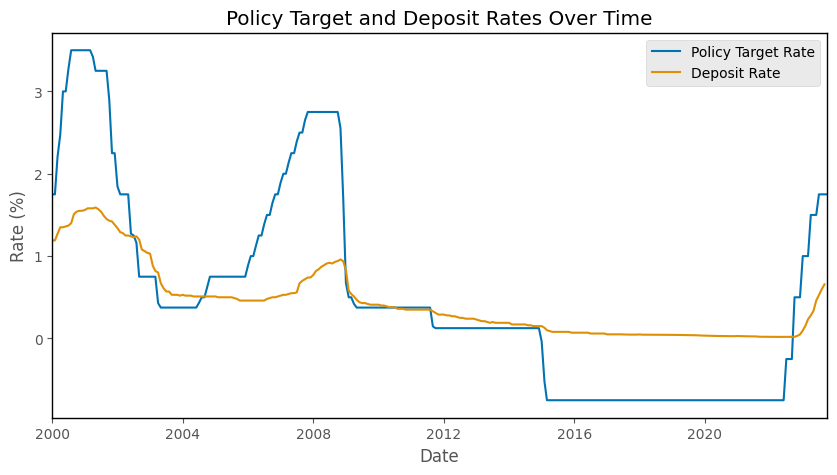

In [99]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns  # For color-blind friendly palette
import os

# Assuming SNB_data is already defined with 'date', 'policy', and 'deposit' columns

# Convert 'date' to datetime if it's not already in that format
SNB_data['date'] = pd.to_datetime(SNB_data['date'])

# Set 'date' as the index
SNB_data.set_index('date', inplace=True)

# Set a color-blind-friendly palette from Seaborn
colors = sns.color_palette("colorblind")

# Create a figure with a white background
plt.figure(figsize=(10, 5), facecolor='white')

# Get the current axis and set the face color to white
ax = plt.gca()
ax.set_facecolor('white')

# Plotting with color-blind friendly colors
plt.plot(SNB_data.index, SNB_data['policy'], label='Policy Target Rate', color=colors[0])
plt.plot(SNB_data.index, SNB_data['deposit'], label='Deposit Rate', color=colors[1])

# Adding title and labels
plt.title('Policy Target and Deposit Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Rate (%)')

# Adding legend
plt.legend()

# Remove the grid
plt.grid(False)

# Add a black square line around the plot
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

# Adjust x-axis limits
data_start_date = SNB_data.index.min()
data_end_date = SNB_data.index.max()
ax.set_xlim(data_start_date, data_end_date)

# Check if the directory exists and create it if not
output_dir = '../reports/figures/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the plot as a PDF file in the specified directory
pdf_file_path = os.path.join(output_dir, 'rates_time_SNB.pdf')
plt.savefig(pdf_file_path, format='pdf', bbox_inches='tight', facecolor='white')

# Display the plot
plt.show()


Function to identify rate hikes
1. Initialization
Hiking List: Initializes a list named hiking, filled with False values, indicating that initially, no period is considered within a hiking cycle.
2. Primary Loop: Hiking Cycle Detection
Rate Increase Check: Starts from the second period, comparing the policy rate with the previous period.
If the rate is higher than the previous, marks it as part of a hiking cycle (True in hiking list).
If not an increase, but the previous was a hiking period, checks the next two periods:
Marks as the end of a cycle (False) if neither shows an increase.
Continues the cycle (True) if any of the next two show an increase.
3. Secondary Loop: Pre-Hiking Adjustment
Economic Anticipation: Adjusts for periods preceding a rate increase.
If a period is followed by an increasing rate, it is also marked as part of the cycle (True), capturing economic anticipation.
4. Special Case Handling
First Period: Treated uniquely. Set to True if the second period is part of a hiking cycle, indicating anticipation of a rate hike.
5. Finalization
DataFrame Update: The hiking list is assigned to the DataFrame's hiking column, indicating the hiking cycle status for each period.
Output: Returns the updated DataFrame with the hiking column.

In [65]:
import pandas as pd

# Assuming SNB_data is already loaded and has a DatetimeIndex

def identify_hiking_cycles(df):
    hiking = [False] * len(df)  # Initialize the list with False

    # First loop: Set the 'hiking' status based on policy rate increases
    for i in range(1, len(df)):
        # If there is an increase in policy rate, set hiking to True
        if df['policy'].iloc[i] > df['policy'].iloc[i - 1]:
            hiking[i] = True
        # Check the next two periods if possible
        elif hiking[i - 1] and i < len(df) - 2:
            # If there are no increases in the next two periods, end the hiking cycle
            if not (df['policy'].iloc[i + 1] > df['policy'].iloc[i] or df['policy'].iloc[i + 2] > df['policy'].iloc[i]):
                hiking[i] = False
            else:
                # Otherwise, continue the hiking cycle
                hiking[i] = True

    # Second loop: Update the 'hiking' status to capture the period before the start of an actual hike
    for i in range(len(df) - 1):
        # If the next period is True, the current period should also be True
        if not hiking[i] and hiking[i + 1]:
            hiking[i] = True

    # Handle the special case of the first period
    if len(df) > 1 and not hiking[0] and hiking[1]:
        hiking[0] = True

    # Set the 'hiking' column in one go to avoid SettingWithCopyWarning
    df['hiking'] = hiking

    return df

# Apply the function to the SNB_data DataFrame
SNB_data = identify_hiking_cycles(SNB_data)

# Display the updated DataFrame
print(SNB_data)


              policy   deposit  hiking
date                                  
2000-01-01  1.750000  1.190000    True
2000-02-01  1.750000  1.190000    True
2000-03-01  2.202381  1.270000    True
2000-04-01  2.478261  1.350000    True
2000-05-01  3.000000  1.350000    True
...              ...       ...     ...
2023-06-01  1.500000  0.460714    True
2023-07-01  1.750000  0.526190    True
2023-08-01  1.750000  0.597059   False
2023-09-01  1.750000  0.656765   False
2023-10-01  1.750000       NaN   False

[286 rows x 3 columns]


Label Hiking Periods

In [66]:
import pandas as pd

# Assuming SNB_data is already loaded and has the 'hiking' column

# Create a boolean series where we shift the 'hiking' column to compare with the next row
hiking_starts = (SNB_data['hiking'] & ~SNB_data['hiking'].shift(1).fillna(False))

# Use cumsum to create a unique identifier for each hiking period
SNB_data['hike_period_id'] = hiking_starts.cumsum()

# Now we create the 'hike_period' column which will be empty initially
SNB_data['hike_period'] = None

# Iterate over the unique hike period ids and set the 'hike_period' for rows where 'hiking' is True
for period_id in SNB_data['hike_period_id'].unique():
    if period_id != 0:  # We don't want to label the non-hiking periods
        SNB_data.loc[(SNB_data['hike_period_id'] == period_id) & SNB_data['hiking'],
                     'hike_period'] = f"hiking period {period_id}"

# Drop the intermediate 'hike_period_id' as it's no longer needed
SNB_data.drop('hike_period_id', axis=1, inplace=True)

# Display the updated DataFrame
print(SNB_data)


              policy   deposit  hiking      hike_period
date                                                   
2000-01-01  1.750000  1.190000    True  hiking period 1
2000-02-01  1.750000  1.190000    True  hiking period 1
2000-03-01  2.202381  1.270000    True  hiking period 1
2000-04-01  2.478261  1.350000    True  hiking period 1
2000-05-01  3.000000  1.350000    True  hiking period 1
...              ...       ...     ...              ...
2023-06-01  1.500000  0.460714    True  hiking period 4
2023-07-01  1.750000  0.526190    True  hiking period 4
2023-08-01  1.750000  0.597059   False             None
2023-09-01  1.750000  0.656765   False             None
2023-10-01  1.750000       NaN   False             None

[286 rows x 4 columns]


Summarize hiking periods and output to a PDF in '../reports/figures/'

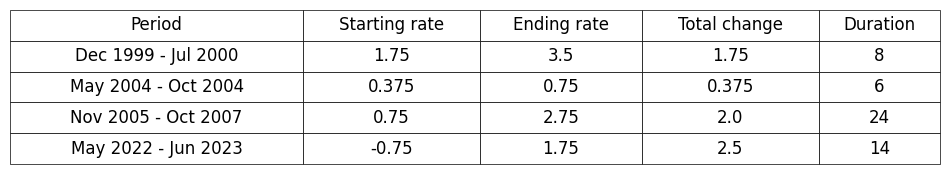

In [68]:
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import os

# Assuming SNB_data is a pre-loaded DataFrame with relevant columns

# Reset the index so that 'date' becomes a column
SNB_data_reset = SNB_data.reset_index()

# Filter the DataFrame to include only the rows where 'hike_period' is not None
hiking_data = SNB_data_reset.dropna(subset=['hike_period'])

# Group by 'hike_period' and calculate the summary statistics
hiking_summary = hiking_data.groupby('hike_period').agg(
    begin_date=('date', 'min'),
    end_date=('date', 'max'),
    begin_policy=('policy', 'first'),
    end_policy=('policy', 'last'),
    change_in_policy=('policy', lambda x: x.iloc[-1] - x.iloc[0]),
    hike_duration=('date', lambda x: ((x.max().year - x.min().year) * 12 + (x.max().month - x.min().month)) + 1)
).reset_index()

# Adjust 'begin_date' and 'end_date' to reflect the previous month's data
hiking_summary['begin_date'] = hiking_summary['begin_date'] - MonthEnd(1)
hiking_summary['end_date'] = hiking_summary['end_date'] - MonthEnd(1)

# Format the 'dates' column as 'month year - month year'
hiking_summary['dates'] = hiking_summary.apply(
    lambda row: f"{row['begin_date'].strftime('%b %Y')} - {row['end_date'].strftime('%b %Y')}", axis=1
)

# Select and order the columns according to the requirements
hiking_summary = hiking_summary[['dates', 'begin_policy', 'end_policy', 'change_in_policy', 'hike_duration']]

# Set the output directory for the figures
output_dir = '../reports/figures/'

# Check if the directory exists, if not, create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Set the style for nicer output
plt.style.use('ggplot')

# Create a new figure with size appropriate for your table
fig, ax = plt.subplots(figsize=(12, 2))  # Adjust the size as needed

# Hide the axes
ax.axis('off')

new_column_names = ['Period', 'Starting rate', 'Ending rate', 'Total change', 'Duration']

# Create the table and adjust properties as needed
tbl = ax.table(cellText=hiking_summary.values,
               colLabels=new_column_names,  # Use the new column names here
               cellLoc='center',
               loc='center',
               bbox=[0, 0, 1, 1])  # bbox ensures the table takes the full figure

# Style the table with a font size and any other properties you like
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.auto_set_column_width(col=list(range(len(hiking_summary.columns))))  # Adjust the columns width to fit content

# Save the figure as PDF
pdf_filename = os.path.join(output_dir, 'hiking_summary_SNB.pdf')
plt.savefig(pdf_filename, bbox_inches='tight')

# Optionally display the figure if you're in a Jupyter environment
plt.show()

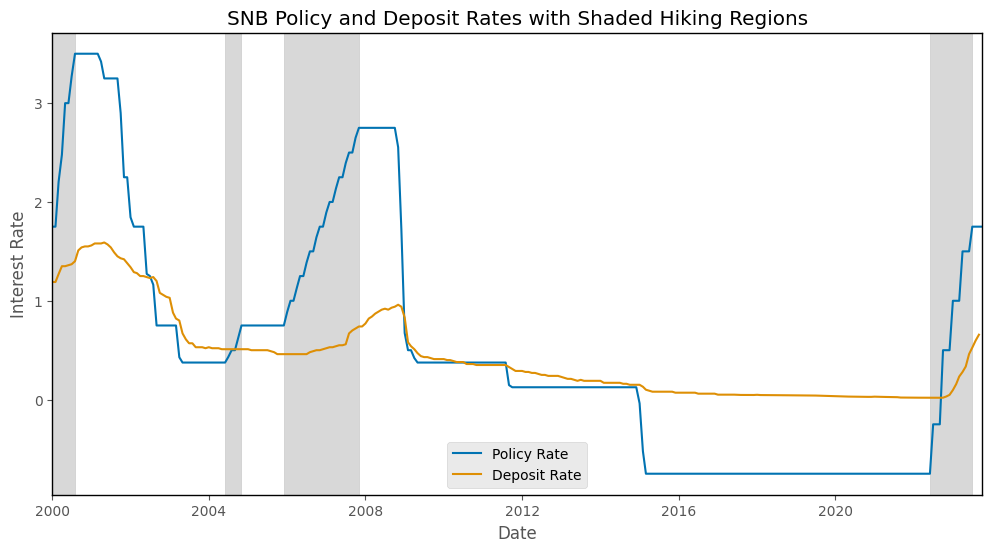

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # For color-blind friendly palette
import os

# Assuming you have 'SNB_data' and 'hiking_regions' dataframes

# Set a color-blind-friendly palette from Seaborn
colors = sns.color_palette("colorblind")

# Create a white background figure
plt.figure(figsize=(12, 6), facecolor='white')

# Get the current axes
ax = plt.gca()
ax.set_facecolor('white')

# Plot the 'policy' rate and the 'deposit' rate using the color-blind friendly colors
plt.plot(SNB_data.index, SNB_data['policy'], label='Policy Rate', color=colors[0])
plt.plot(SNB_data.index, SNB_data['deposit'], label='Deposit Rate', color=colors[1])

# Shade the regions specified in 'hiking_regions'
for _, row in hiking_regions.iterrows():
    plt.axvspan(row['start_date'], row['end_date'], color='gray', alpha=0.3)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.title('SNB Policy and Deposit Rates with Shaded Hiking Regions')
plt.legend()

# Remove the grid
plt.grid(False)

# Add a black square line around the plot
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

# Adjust x-axis limits
data_start_date = SNB_data.index.min()
data_end_date = SNB_data.index.max()
ax.set_xlim(data_start_date, data_end_date)

# Check if the directory exists and create it if not
output_dir = '../reports/figures/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the plot as a PDF file in the specified directory
pdf_file_path = os.path.join(output_dir, 'rates_shaded_SNB.pdf')
plt.savefig(pdf_file_path, format='pdf', bbox_inches='tight', facecolor='white')

# Show the plot
plt.show()
